# USIO - Energy Consumption Forecasting Exercise

In this notebook we provide a brief introduction of the data structure and introduce the training model used for making forecasts. 

### Exploratory data analysis

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV
from sklearn.externals import joblib
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

In [2]:
# read the data
tr_url = 'https://raw.githubusercontent.com/Usio-Energy/data-science-exercise/master/usage_train.csv'

tr_data = pd.read_csv(tr_url)
tr_data['datetime'] = pd.to_datetime(tr_data['datetime'])
tr_data = tr_data.set_index('datetime')
print(tr_data.head(5))

                            id  usage
datetime                             
2012-12-17 09:00:00  MAC003828  0.073
2012-12-17 09:30:00  MAC003828  0.054
2012-12-17 10:00:00  MAC003828  0.069
2012-12-17 10:30:00  MAC003828  0.070
2012-12-17 11:00:00  MAC003828  0.049


The dataset contains household ids and usage associated to each time stamp. Let's take a look at how many households are represented per time stamp.

In [3]:
tr_data.groupby('datetime').usage.count().describe()

count    17184.0
mean        10.0
std          0.0
min         10.0
25%         10.0
50%         10.0
75%         10.0
max         10.0
Name: usage, dtype: float64

So we have 10 observation per time stamp. Let's now check for missing data.

In [4]:
tr_data.isnull().sum()

id       0
usage    0
dtype: int64

No data is missing so there are no specific adjustments required to the data. What time periods are included in the subject time interval?

In [5]:
print('The first time stamp is',tr_data.index.min())
print('The last time stamp is', tr_data.index.max())

The first time stamp is 2012-12-17 09:00:00
The last time stamp is 2013-12-10 08:30:00


So how is the variable of interest distributed? Let's plot hourly averages throughout the full time period underlying the training set.

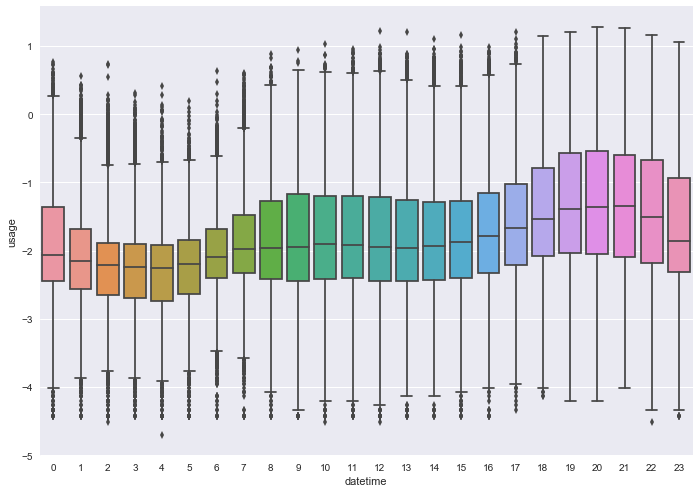

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(y=np.log(tr_data['usage']), x = tr_data.index.hour)

This plot provides just a rough idea of the underliying distribution. A few notes regarding the interpretation:

* The values are displayed on a log scale in order to center the distribution.
* We are plotting information retrieved over the course of an (almost) full year, so at least part of the oscillations are justified by the fact that we are considering every day of the week and every season of the year. 
* We are considering information pertaining to all 10 households included in the set, and we have no idea whether those households are representative of the wider population.

In order to investigate the matter in more depth, we should break down the analysis according to each of the variables mentioned above, but that sort of exercise is beyond the objectives of this work.

### Training the model

In this section we will perform some pre-processing prior to feeding the dataset to the machine learning algorithm.

For each observation, we are adding the energy consumption history for the prior two weeks and also adding some categorical features - immediately converted to numeric variables via 1-hot encoding.

Lastly, we separate the labels 'tr_labels' from the explanatory variables 'tr_feat'.

In [7]:
for i in range(1,336*2):
    tr_data['lag_{}'.format(i)] = tr_data.usage.shift(i)
    
#tr_data['minute'] = tr_data.index.minute
tr_data['hour'] = (tr_data.index.hour.astype(str) + ':' +
       tr_data.index.minute.astype(str))
tr_data['weekday'] = tr_data.index.weekday # 5 and 6 represent weekends
tr_data['is_weekend'] = tr_data.weekday.isin([5,6])*1
tr_data['month'] = tr_data.index.month
tr_data = pd.get_dummies(tr_data, 
                         columns = ['id','hour','weekday','month'],
                    prefix=['id','hour','day','month'])#, drop_first = True)
tr_data = tr_data.dropna()

tr_labels = tr_data['usage']
tr_feat = tr_data.drop('usage',axis = 1)

Now let's declare the parameters of our model (we are using Elastic Net in this setting) and train it.

In [8]:
model = ElasticNetCV(cv= 10, 
                     normalize = True,
                     fit_intercept = False,
                     random_state = 1, 
                     #max_iter = 10000,
                     n_jobs = -1, 
                     selection = 'random')

model_fit = model.fit(tr_feat, tr_labels)

Now that this is done, we can investigate the model 'alpha' to see how much the net is skewed towards the L1 vs the L2 penalty term, and most importantly calculate the Root Mean Squared Error.

In [9]:
print('Alpha for the estimated model is:', model_fit.alpha_) 

tr_yhat = model_fit.predict(tr_feat)
MSE = mean_squared_error(tr_labels, tr_yhat)

print('Mean Squared Error on the training set is:', np.sqrt(MSE))

Alpha for the estimated model is: 0.00041109494395472025
Mean Squared Error on the training set is: 0.1805177335365133


How many features were retained out of all features supplied? (Check out the appendix at the end of the document to verify what was retained.)

In [10]:
total_f = len(model_fit.coef_)
retained_f = sum(model_fit.coef_ != 0)

print(retained_f, 'features retained out of', total_f,
      'initial features')

173 features retained out of 749 initial features


Finally, we plot true labels vs predictions to see, visually and intuitively, how well our model is doing.

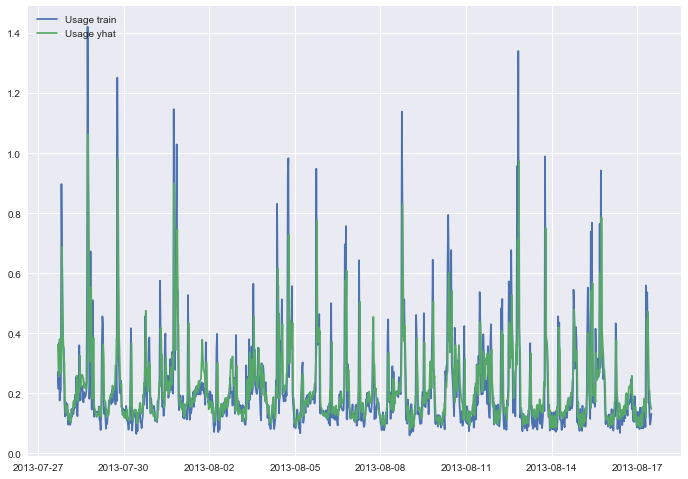

In [11]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.plot(tr_data.index[10000:11000], tr_data.usage[10000:11000],
         tr_data.index[10000:11000], tr_yhat[10000:11000])
plt.legend(['Usage train', 'Usage yhat'], loc = 'upper left')

From a visual inspection, it seems that our model fails to account for peak usage. That is an issue which opens further scenarios of analysis.

Thank you for reviewing this work :)

### Appendix: list of retained variables

In [12]:
np.array(list(tr_feat))[model_fit.coef_ != 0]

array(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_8',
       'lag_11', 'lag_17', 'lag_18', 'lag_20', 'lag_21', 'lag_23',
       'lag_24', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_42',
       'lag_43', 'lag_44', 'lag_45', 'lag_46', 'lag_47', 'lag_48',
       'lag_49', 'lag_51', 'lag_56', 'lag_72', 'lag_74', 'lag_80',
       'lag_87', 'lag_88', 'lag_93', 'lag_94', 'lag_95', 'lag_96',
       'lag_98', 'lag_103', 'lag_106', 'lag_107', 'lag_109', 'lag_119',
       'lag_132', 'lag_135', 'lag_139', 'lag_141', 'lag_143', 'lag_144',
       'lag_147', 'lag_163', 'lag_172', 'lag_175', 'lag_184', 'lag_191',
       'lag_192', 'lag_197', 'lag_204', 'lag_205', 'lag_214', 'lag_227',
       'lag_234', 'lag_239', 'lag_240', 'lag_242', 'lag_243', 'lag_246',
       'lag_248', 'lag_258', 'lag_274', 'lag_280', 'lag_284', 'lag_285',
       'lag_286', 'lag_287', 'lag_288', 'lag_290', 'lag_291', 'lag_292',
       'lag_293', 'lag_294', 'lag_296', 'lag_298', 'lag_301', 'lag_302',
       'lag_

One quick note regarding this appendix is that three out of ten household ids were retained. In other words, this could be taken as a first indication that three households behave differently than the average. This is another phenomenon which could be investigated further.